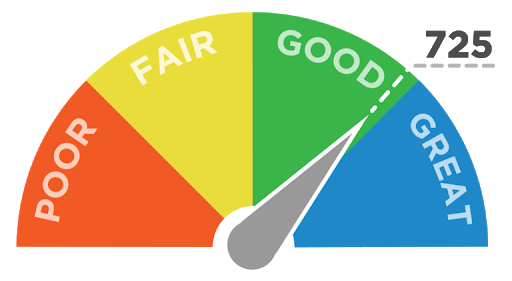

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from xgboost import plot_tree

from lightgbm import LGBMClassifier


from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import calibration_curve

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
warnings.filterwarnings("ignore")

# списки признаков, разделенных по типу переменных
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work','foreign_passport']


'''функция для подсчета пропущенных значений и их процента от общего числа значений'''


def missing_table(df):
    mis_val = df.isnull().sum()
    percent = 100 * df.isnull().sum() / len(df)
    mis_table = pd.DataFrame({
        'Missing Values': mis_val,
        '% of Total Values': percent
    })
    return mis_table


'''функция, выводящая heatmap для пропущенных значений'''


def isnull_heatmap(df):
    fig, ax = plt.subplots(figsize=(20,12))
    sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='Blues')
    return sns_heatmap


'''функция, выводящая средние показатели: mean, median, mode'''


def mid_val(df, column):
    median = df[column].median()
    mode = df[column].mode()
    mean = df[column].mean()
    return display(pd.DataFrame({'Признак': column, 'Медиана': median, 'Среднее': mean, 'Мода': mode}))


'''функция, выводящая графики распределения непрерывных переменных'''


def distplot_num(df):
    for i in num_cols:
        plt.figure()
        sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
        plt.title(i)
        plt.show()
        

'''функция, выводящая все уникальные значения и их количество'''
    
def cat_values(df, column):
    display(pd.DataFrame(df[column].value_counts(dropna=True)))
    sns.catplot(x=column, kind="count", palette="Blues", data=df)
    
    
'''функция для создания категориального признака на основе количества запросов в БКИ'''


def bki_request_groups(row):
    if row['bki_request_cnt'] < 12:
        return 1
    else:
        return 0

    
'''функция, логарифмирующая числовые данные'''


def log_num(df):
    for i in num_cols:
        if i != 'score_bki':
            log_val(df, i)
            
            
'''функция, логарифмирующая данные'''


def log_val(df,column):
    df[column] = df[column].apply(lambda w: np.log(w + 1))
    
    
'''функция, выводящая график плотности распределения переменных (boxplot)'''

def get_boxplot(df, column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x="default", y=column, data=df, palette="Blues",
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
 
    
    
'''функция ROC-AUC кривой'''


def roc_auc_curve(y_test, y_probs, string, string_1):
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label= string_1)
    plt.title(string % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    
'''функция выводящая classification report и confusion matrix'''


def class_matrix(y_test, y_pred, string):
    print(classification_report(y_test, y_pred))


    fig, ax = plt.subplots()
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'),
            annot=True,
            ax=ax)
    ax.set_title(string)
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Real Value')

    plt.show()
    
    
'''функция, выводящая метрики качества модели'''


def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')


In [2]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

В этом проекте нам необходимо установить вероятность дефолта клиента по некоторым данным. Рассмотрим данные подробнее:

| Название столбца | Содержание                     |
|:-----------------|:---------------------------------|
| client_id | идентификатор клиента |
| education | уровень образования |
| sex | пол заемщика |
| age | возраст заемщика |
| car | флаг наличия автомобиля |
| car_type | флаг автомобиля иномарки |
| decline_app_cnt | количество отказанных прошлых заявок |
| good_work | флаг наличия “хорошей” работы |
| bki_request_cnt | количество запросов в БКИ |
| home_address | категоризатор домашнего адреса |
| work_address | категоризатор рабочего адреса |
| income | доход заемщика |
| foreign_passport | наличие загранпаспорта |
| sna | связь заемщика с клиентами банка |
| first_time | давность наличия информации о заемщике |
| score_bki | скоринговый балл по данным из БКИ |
| region_rating | рейтинг региона |
| app_date | дата подачи заявки |
| default | флаг дефолта по кредиту |

In [3]:
print(f'Размерность обучающей выборки:', train.shape)
print(f'Размерность тестовой выборки:', test.shape)
print(f'Размерность примера submission:', sample_submission.shape)

Размерность обучающей выборки: (73799, 19)
Размерность тестовой выборки: (36349, 18)
Размерность примера submission: (24354, 2)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


Размерность обучающей выборки выше тестовой в два раза.  
Нам так же дан пример сабмита. В нем две колонки: идентификатор клиента и наши предсказания дефолта.

In [7]:
# определим для последующего submission одну из колонок
client_test = test['client_id']

## 'default'  
Прежде чем приступить к анализу, рассмотрим целевую переменную. Мы видели, что ее (ожидаемо) нет в тестовой выборке.

,default
0,64427
1,9372


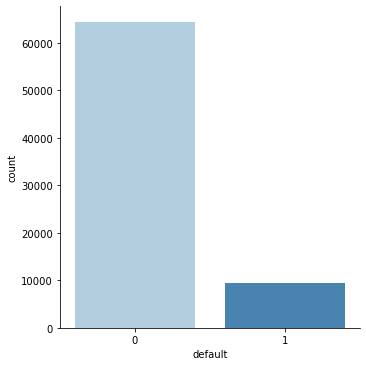

In [8]:
cat_values(train, 'default')

In [9]:
# узнаем доли каждого класса
train['default'].value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

Мы видим сильный дисбаланс в целевой переменной. Non-default значения превышают в 7 раз дефолтные.  
Попробуем применить несколько методов: прямо указать класс весов в LogisticRegression(), oversampling, и другие модели.  
Я пробовала применить и undersampling, но на сабмитах score был ниже. Это логично, так как мы лишали модель доступа к большому количеству данных для обучения.

Итак, определим вес каждого класса  
Мы знаем что вес каждого класса рассчитывается по формуле:

                         вес класса = общее количество строк в признаке/(число уникальных классов * число строк класса)

In [10]:
# определяем пустой словарь
weights={}

# высчитываем число строк каждого класса
majority_cnt = train['default'].value_counts()[0]
minority_cnt = train['default'].value_counts()[1]

# высчитываем веса классов
w0 = len(train)/(2*majority_cnt)
w1 = len(train)/(2*minority_cnt)


weights[0] = w0
weights[1] = w1
print(weights)

{0: 0.572733481304422, 1: 3.937206572769953}


In [11]:
# oversampling
# будем параллельно его обрабатывать, чтобы ничего не забыть

train_0 = train[train.default == 0]
train_1 = train[train.default == 1]

# Генерируем классу-меньшинству данные
train_upsampled = resample(
    train_1,
    replace=True,
    n_samples=majority_cnt,  # чтобы число совпало с классом-большинством
    random_state=123)  # reproducible results

# Объединяем датасеты
train_oversampled = pd.concat([train_0, train_upsampled])

# Посмотрим, что у нас получилось
train_oversampled.default.value_counts()

1    64427
0    64427
Name: default, dtype: int64

Разделим признаки по типу переменных:

* количественные: age, decline_app_cnt, bki_request_cnt, income, score_bki
* категориальные: education, home_address, work_address, sna, first_time, region_rating
* бинарные: sex, car, car_type, good_work, foreign_passport

# Работа с пропусками

<AxesSubplot:>

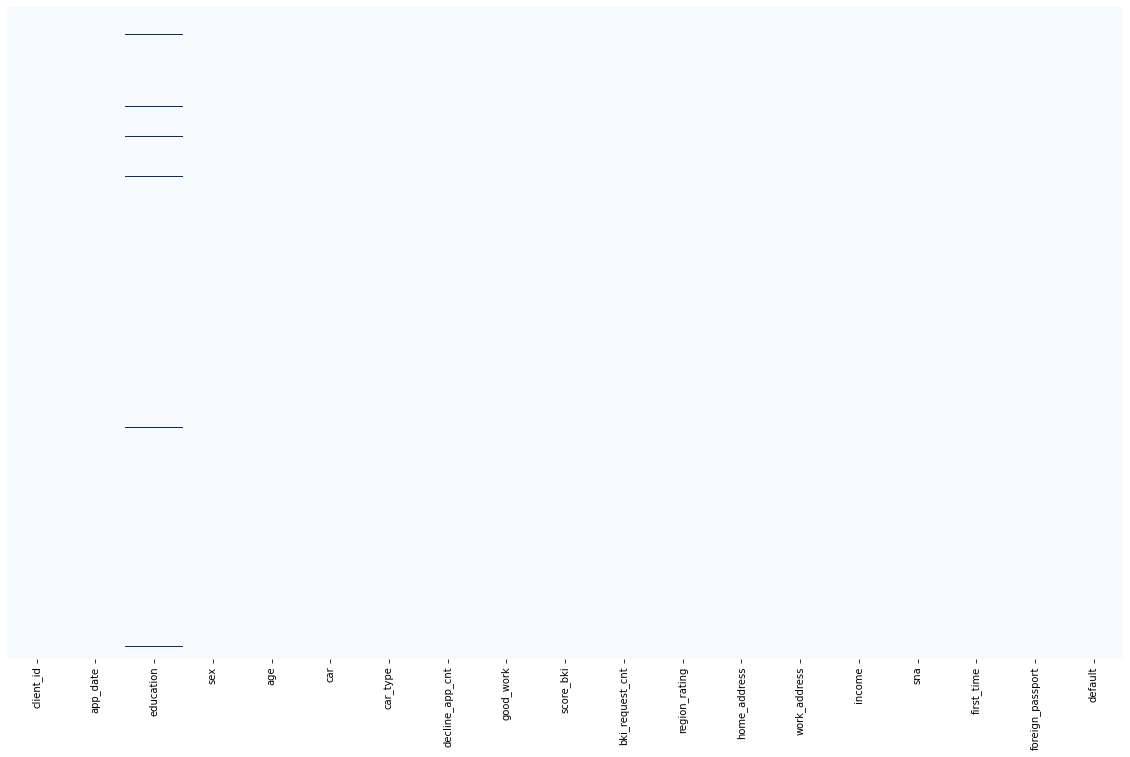

In [12]:
isnull_heatmap(train)

In [13]:
missing_table(train)

,Missing Values,% of Total Values
client_id,0,0.000000
app_date,0,0.000000
education,307,0.415995
sex,0,0.000000
age,0,0.000000
car,0,0.000000
car_type,0,0.000000
decline_app_cnt,0,0.000000
good_work,0,0.000000
score_bki,0,0.000000


<AxesSubplot:>

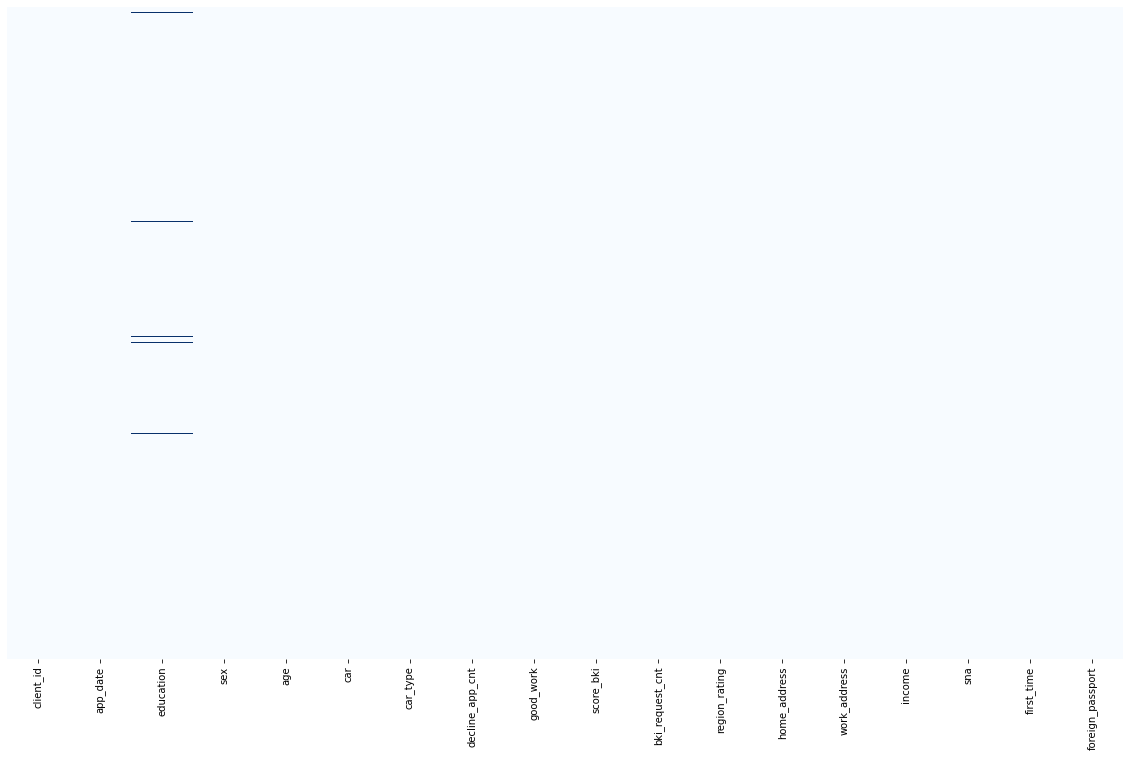

In [14]:
isnull_heatmap(test)

In [15]:
missing_table(test)

,Missing Values,% of Total Values
client_id,0,0.000000
app_date,0,0.000000
education,171,0.470439
sex,0,0.000000
age,0,0.000000
car,0,0.000000
car_type,0,0.000000
decline_app_cnt,0,0.000000
good_work,0,0.000000
score_bki,0,0.000000


'education' - единственный признак с пропущенными значениями. Причем их доля в обучающей и тестовой выборке составляет по чуть более 0.4%  
Рассмотрим его подробнее

,education
SCH,38860
GRD,23365
UGR,9816
PGR,1257
ACD,194


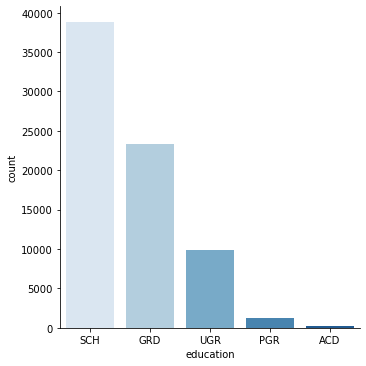

In [16]:
cat_values(train, 'education')

,education
SCH,19138
GRD,11403
UGR,4932
PGR,608
ACD,97


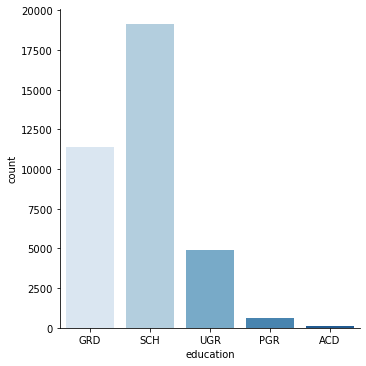

In [17]:
cat_values(test, 'education')

Рада, что данные распределены примерно равно по обеим выборкам.  
Большинство потенциальных заемщиков (более 50%) имеют лишь оконченное школьное образование.
Интересно, что бакалавров существенно меньше, чем магистров. Возможно, это связано с тем, что в России большинство вузов предлагают специалитет, а не бакалавриат. Но нам, к сожалению, неизвестно по каким параметрам распределяли респондентов между UGR и GRD  

Я решила заполнить пропуски модой, т.к. 0.4-0.5% существенно на распределение не повлияют.  
В отдельную категорию 'unknown' я не стала выводить, так как вряд ли есть другие категории в данном вопросе, и пропусков немного

In [18]:
train['education'] = train['education'].fillna(train['education'].mode()[0])

test['education'] = test['education'].fillna(test['education'].mode()[0])

train_oversampled['education'] = train_oversampled['education'].fillna(
    train_oversampled['education'].mode()[0])

# Категориальные переменные

Раз уж мы начали с 'education', продолжим рассматривать столбцы по тому же типу переменных

,home_address
2,39956
1,32585
3,1258


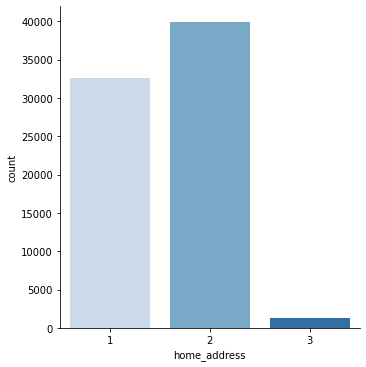

In [19]:
cat_values(train,'home_address')

,work_address
3,44959
2,20506
1,8334


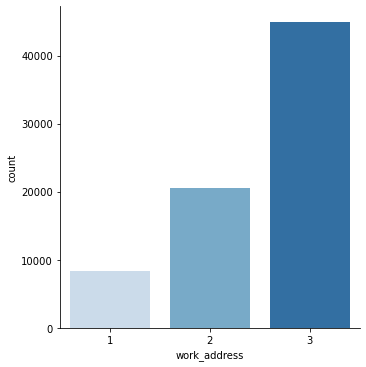

In [20]:
cat_values(train, 'work_address')

,sna
1,47301
4,11749
2,10626
3,4123


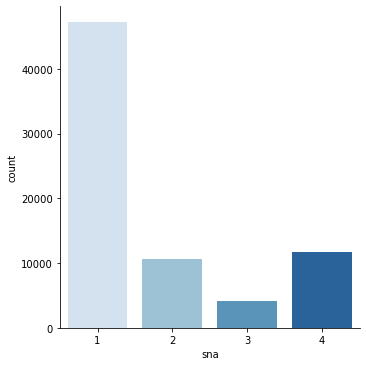

In [21]:
cat_values(train, 'sna')

,first_time
3,31255
4,18737
1,12239
2,11568


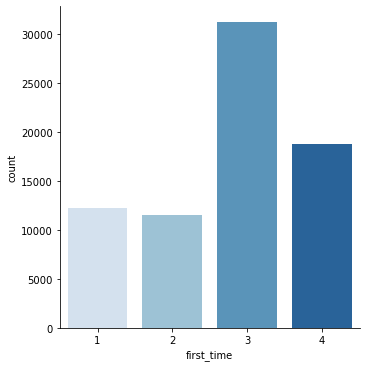

In [22]:
cat_values(train, 'first_time')

,region_rating
50,27523
60,16075
40,12027
80,11469
70,6199
30,300
20,206


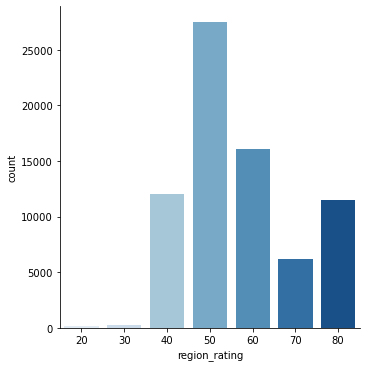

In [23]:
cat_values(train, 'region_rating')

На самом деле, мы можем только догадываться, что могут обозначать категории в цифровом формате. Статус района/региона?  
Как единица(1) характеризует связь заемщика с клиентами банка? Пользуется всевозможными услугами и поэтому ранжируется первым, или же в первый раз пришел?  
Указывает ли степень родственных связей, или количество его коллег?  
Самая ранняя информация о заемщике это 1 или 4?

Поэтому максимум, что мы сможем сделать с ними - проверить корреляцию между признаками, значимость переменных и подготовить к обучению

# Бинарные переменные

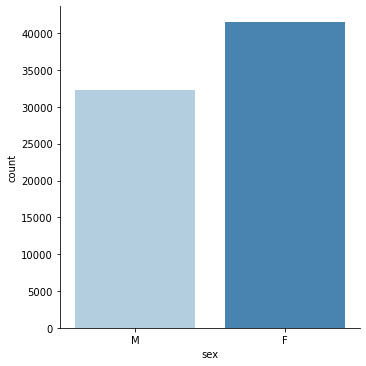

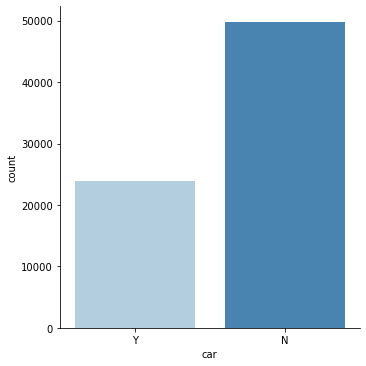

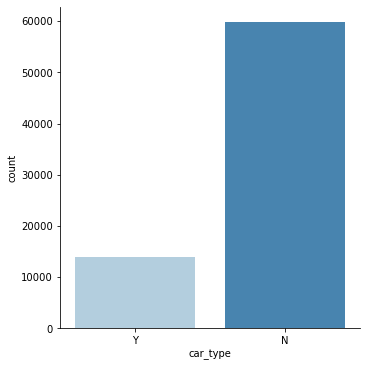

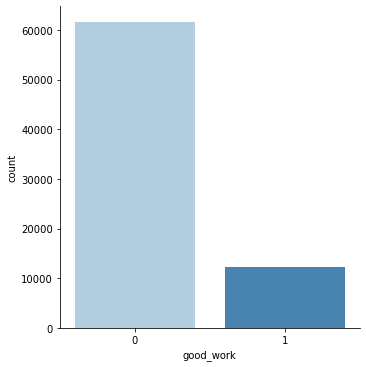

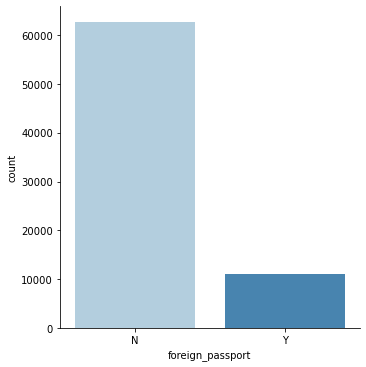

In [24]:
for col in bin_cols:
    sns.catplot(x=col, kind="count", palette="Blues", data=train)

По графикам мы видим, что:

* женщин среди заемщиков больше
* владельцы любых автомобилей составляют меньшинство среди всех потенциальных заемщиков
* маркер 'хорошей' работы встречается редко, что, наверное, логично
* у большинства заемщиков заграничных паспортов нет

# Количественные переменные

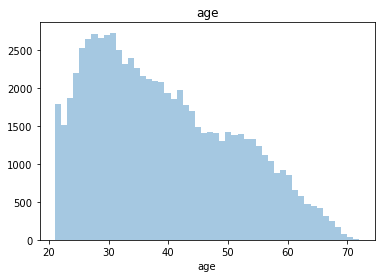

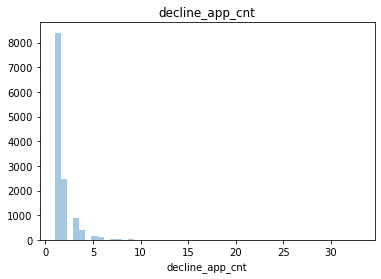

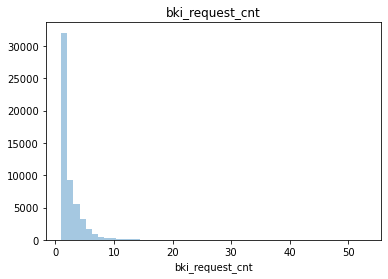

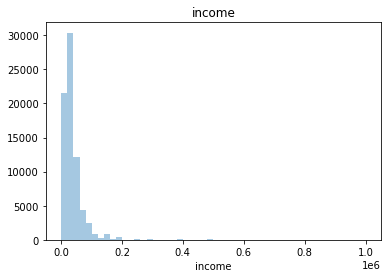

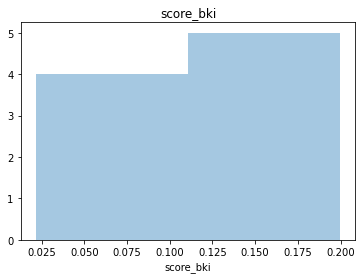

In [25]:
# Взглянем на распределение данных
distplot_num(train)

<AxesSubplot:>

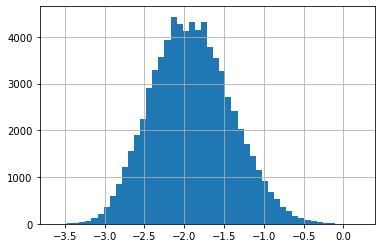

In [26]:
# рассмотрим отдельно score_bki
train['score_bki'].hist(bins=50)

Мы видим тяжелый правый хвост в данных, прологарифмируем их и взглянем еще раз  
Однако признак score_bki распределен нормально, так что его мы не тронем

In [27]:
# создадим новый признак-группировку, ниже я объясню почему сейчас и почему именно такой
train['bki_request_groups'] = train.apply(bki_request_groups, axis=1)
test['bki_request_groups'] = test.apply(bki_request_groups, axis=1)

train_oversampled['bki_request_groups'] = train_oversampled.apply(
    bki_request_groups, axis=1)

# добавляем столбец в список категориальных переменных
cat_cols.append('bki_request_groups')

In [28]:
# логарифмируем данные
log_num(train)
            
# и то же самое для тестовой выборки:
log_num(test)
            
#oversampled
log_num(train_oversampled)

Посмотрим на другие статистические данные

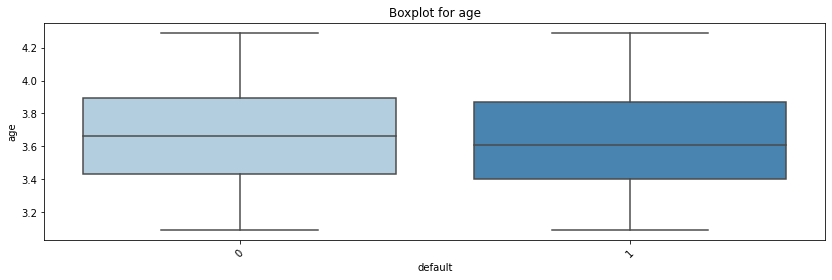

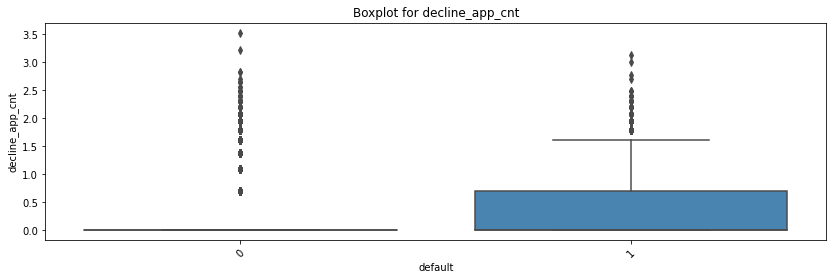

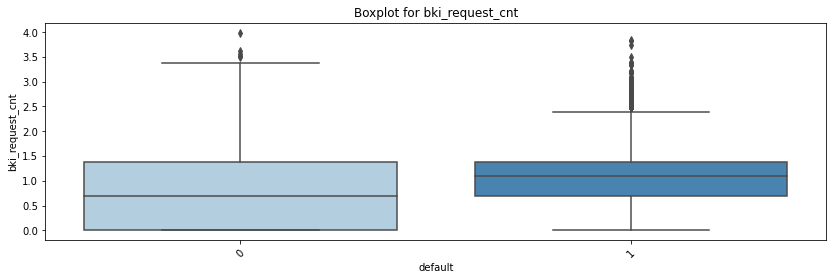

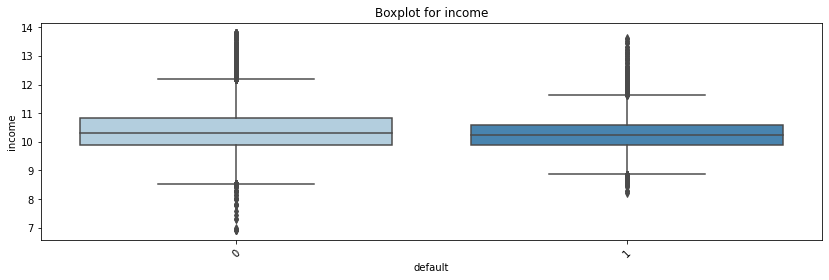

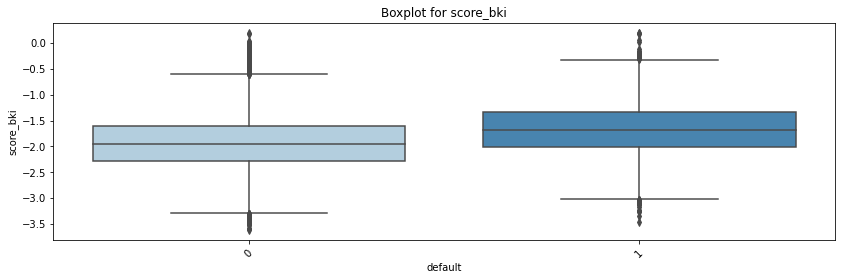

In [29]:
for col in num_cols:
    get_boxplot(train, col)

In [30]:
for col in num_cols:
    mid_val(train, col)

,Признак,Медиана,Среднее,Мода
0,age,3.637586,3.655332,3.465736


,Признак,Медиана,Среднее,Мода
0,decline_app_cnt,0.0,0.152451,0.0


,Признак,Медиана,Среднее,Мода
0,bki_request_cnt,0.693147,0.878014,0.0


,Признак,Медиана,Среднее,Мода
0,income,10.308986,10.345886,10.308986


,Признак,Медиана,Среднее,Мода
0,score_bki,-1.920823,-1.904724,-1.775263


После логарифмирования данных распределение улучшилось и меры центральной тенденции выглядят вполне неплохо, поэтому я решила не удалять выбросы, но на это есть и другие причины:

* 'age' - выбросов нет, распределение после нашей операции улучшилось

* 'decline_app_cnt' - тяжелый правый хвост остался, но удалять выбросы я не стану, так как не уверена смешаны ли здесь отказы как кредиторов так и самого заемщика. В статье Ведомостей сказано :

* Отказ от получения одобренного займа будет рассматриваться, скорее, с положительной стороны. Значит, это разборчивый клиент, которому что-то не понравилось в принятом кредитором решении< https://www.vedomosti.ru/finance/blogs/2019/02/21/794803-isportit-reputatsiyu-zaemschika

* 'bki_request_cnt' - ситуация здесь лучше чем в предыдущем признаке, однако так же есть выбросы и распределение так с правым хвостом. Думаю, здесь можно будет создать новый признак на его основе. По поводу количества запросов я нашла такую информацию:

    В самих БКИ утверждают, что количество просмотров кредитной истории на скоринговый балл заемщика значимого влияния не оказывает. «Их вес среди всех факторов, оказывающих влияние на скоринговый балл, не превышает 10—15%», — отмечают в «Эквифаксе».< https://www.banki.ru/news/daytheme/?id=10908958
  
    Казалось бы, раз большого влияния не оказывает, можно спокойно удалить выбросы. Однако следующая найденная информация натолкнула на мысль, что можно создать на его основе другой признак - было ли количество запросов больше 12 или нет:
  
    Как пояснили в ОКБ, скоринговый балл снижается в том случае, если за год к кредитной истории человека обращались более 12 банков без предложения кредитных продуктов. < https://pravo.ru/news/212992/
  
    Другой вопрос, что признак нужно будет создать до логарифмирования.
 
* 'income' - важный признак, и пусть выбросов всего 6%, пока не хочется терять их. К сожалению, цифры мне ни о чем говорят, ни в каких именно условных единицах они, при минимальном доходе в 1000 у.е. и максимальном в 1000000

* 'score_bki' - распределен признак изначально нормально, но у нас нет сведений о том, как он был рассчитан, так что тут снова не считаю удаление признаков целесообразным

<AxesSubplot:>

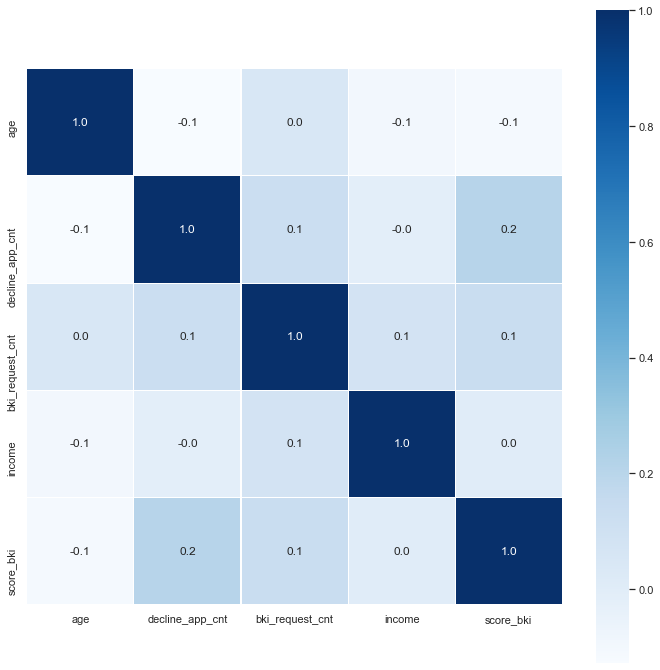

In [31]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train[num_cols].corr(),
            square=True,
            annot=True,
            fmt=".1f",
            linewidths=0.1,
            cmap="Blues")

Сильных корреляций между признаками нет

# Новые признаки

Помимо созданного 'bki_request_groups' я вижу возможность создания новых признаков только на основе даты заполнения заявки, ввиду того, что мы не знаем, по каким именно критериям были распределены значения

In [32]:
# Преобразуем для начала в формат дат
train['app_date'] = pd.to_datetime(train['app_date'], format='%d%b%Y')

test['app_date'] = pd.to_datetime(test['app_date'], format='%d%b%Y')

train_oversampled['app_date'] = pd.to_datetime(train_oversampled['app_date'], format='%d%b%Y') 

In [33]:
train['app_date'].max()

Timestamp('2014-04-30 00:00:00')

Последняя анкета была заполнена в 2014 году, так что не вижу смысла в создании признака давности даты заполнения от сегодняшнего дня.
Попробуем выделить месяц, день и день недели.  
Вряд ли есть зависимость дефорта от начала/конца недели/месяца, но попытаться стоит

In [34]:
train['app_month'] = train['app_date'].dt.month

test['app_month'] = test['app_date'].dt.month

train_oversampled['app_month'] = train_oversampled['app_date'].dt.month

cat_cols.append('app_month')

,app_month
3,21178
2,18028
4,17683
1,16910


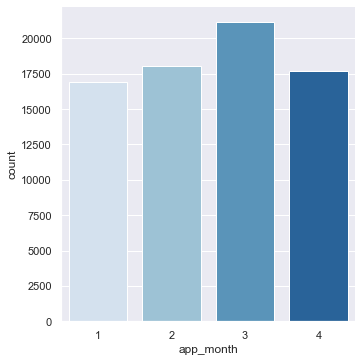

In [35]:
cat_values(train, 'app_month')

In [36]:
#создаем так же признак дня в месяце
train['app_day'] = train['app_date'].dt.day

test['app_day'] = test['app_date'].dt.day

train_oversampled['app_day'] = train_oversampled['app_date'].dt.day

cat_cols.append('app_day')

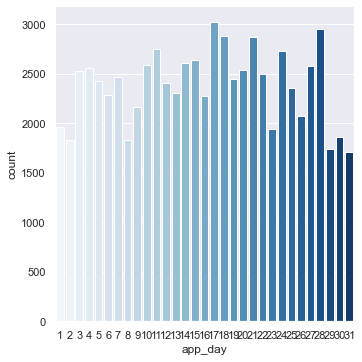

In [37]:
sns.catplot(x='app_day', kind="count", palette="Blues", data=train)

In [38]:
train['app_date'].value_counts(ascending=False)

2014-03-18    1018
2014-03-17     911
2014-03-19     909
2014-03-31     904
2014-04-07     882
              ... 
2014-04-20     243
2014-01-07     228
2014-01-03     193
2014-01-02     137
2014-01-01      43
Name: app_date, Length: 120, dtype: int64

Сильной разницы между месяцами и днями нет. Интересно, что в начале и конце месяца меньше всего заявок  
В январе, после трат на новогодние подарки, меньше всего запросов.  
Догадкой относительно марта было 8 марта, но нет, мы видим, что больше всего заявок было подано 17-19 марта.  
Можно было бы подумать на Наурыз, но даже в Казахстане дорогостоящих подарков/пышных празднеств не устраивают=)

In [39]:
# создаем признак дня недели
train['app_weekday'] = train['app_date'].dt.dayofweek

test['app_weekday'] = test['app_date'].dt.dayofweek

train_oversampled['app_weekday'] = train_oversampled['app_date'].dt.dayofweek

cat_cols.append('app_weekday')

,app_weekday
1,12176
0,12024
2,11740
3,11615
4,11263
5,8231
6,6750


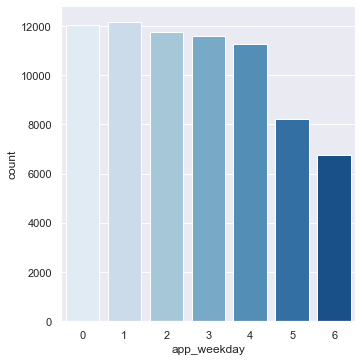

In [40]:
cat_values(train, 'app_weekday')

Первые три дня недели показывают наибольшее количество заявок на заем

# Значимость переменных

In [41]:
# прежде чем определять значимость, переведем строковые выражения столбца с образованием в числовой формат

label_encoder = LabelEncoder()

label_encoder.fit(train["education"])
train["education"] = label_encoder.transform(train["education"])

label_encoder.fit(test["education"])
test["education"] = label_encoder.transform(test["education"])

label_encoder.fit(train_oversampled["education"])
train_oversampled["education"] = label_encoder.transform(train_oversampled["education"])

Text(0.5, 1.0, 'Significance of cat variables')

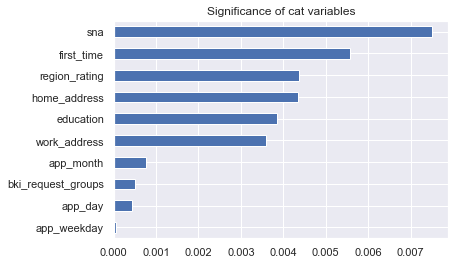

In [42]:
# для оценки категориальных и бинарных переменных будем использовать функцию mutual_info_classif
imp_cat = pd.Series(mutual_info_classif(train[cat_cols],
                                        train['default'],
                                        discrete_features=True),
                    index=train[cat_cols].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

Наибольшую значимость имеет связь клиента с банком и давность наличия информации о заемщике  
Созданные признаки имеют самую небольшую значимость

In [43]:
# для проверки значимости бинарных переменных нужно так же перевести все строковые значения в числовые

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])
    
for column in bin_cols:
    train_oversampled[column] = label_encoder.fit_transform(
        train_oversampled[column])

Text(0.5, 1.0, 'Значимость бинарных переменных')

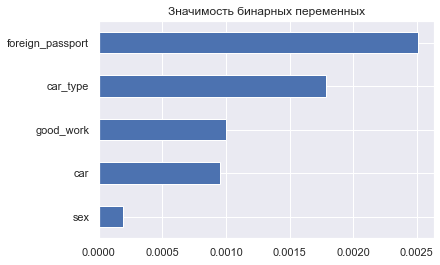

In [44]:
imp_bin = Series(mutual_info_classif(train[bin_cols],
                                     train['default'],
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных переменных')

Интересно, что наличие загранпаспорта влияет на определение дефолта больше чем маркер хорошей работы.  
Зависит ли это от того, что люди берут кредит для путешествий, или не берут в кредит товар на родине имея возможность купить за границей не очень ясно.

<AxesSubplot:>

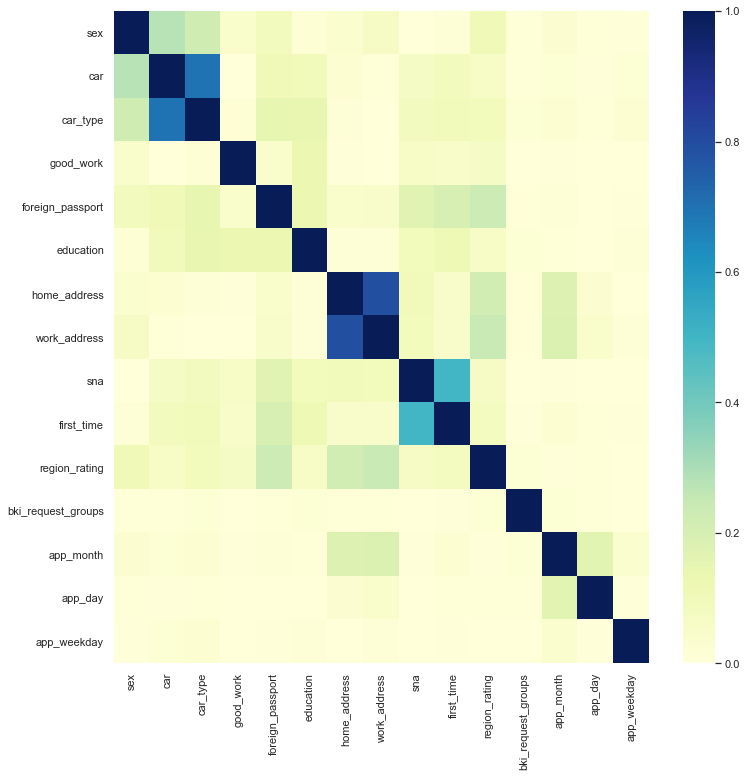

In [45]:
# построим матрицу ранговой корреляции Спирмана
plt.subplots(figsize=(12, 12))
sns.heatmap(train[bin_cols + cat_cols].corr(method='spearman').abs(), vmin=0, vmax=1, cmap="YlGnBu")

Видно сильную корреляцию между наличием автомобиля и иномарки, и между домашним и рабочим адресом.  
По степени значимости кандидаты на удаление: 'car', 'work_address'  
С их удалением качество предсказаний упало

Text(0.5, 0, 'F-value')

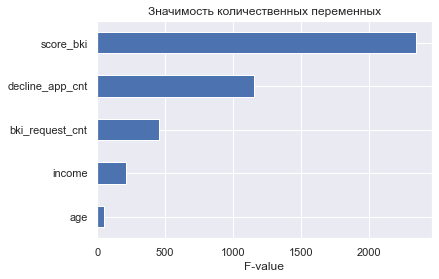

In [46]:
# для оценки непрерывных значений будем использовать функцию f_classif 
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость количественных переменных')
plt.xlabel('F-value')

Тут, логично, на первом месте скоринговый балл по данным из БКИ.  
Но судя по данным, отказы и запросы все же влияют существенно на итоговую оценку, несмотря на заявления ОКБ и БКИ.  
Рада, что эйджизм в банковской сфере не проявляется.

# Подготовка данных

In [47]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
test_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

X_cat_over = OneHotEncoder(sparse = False).fit_transform(train_oversampled[cat_cols].values)

X_num = StandardScaler().fit_transform(train[num_cols].values)
test_num = StandardScaler().fit_transform(test[num_cols].values)

X_num_over = StandardScaler().fit_transform(train_oversampled[num_cols].values)

X = np.hstack([X_num, train[bin_cols].values, X_cat])
y = train['default'].values

X_over = np.hstack([X_num_over, train_oversampled[bin_cols].values, X_cat_over])
y_over = train_oversampled['default'].values

test_X = np.hstack([test_num, test[bin_cols].values, test_cat])

In [48]:
# разбиваем нашу выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [49]:
# разбиение выборки для oversampled датасета
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, test_size=0.20, random_state=42)

# LogisticRegression.  Unbalanced

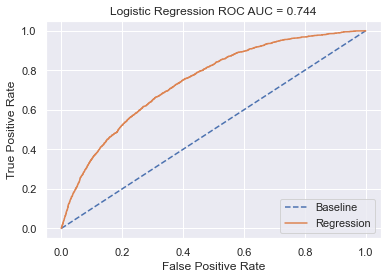

In [50]:
model = LogisticRegression(class_weight = weights, random_state=42)
model.fit(X_train, np.ravel(y_train))

probs = model.predict_proba(X_test)
probs = probs[:, 1]

# строим кривую
roc_auc_curve(y_test, probs, 'Logistic Regression ROC AUC = %0.3f', 'Regression')

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



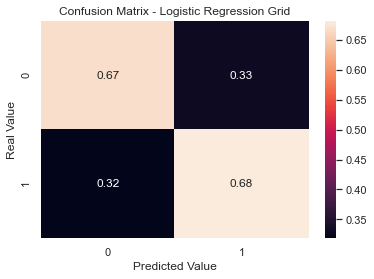

In [51]:
y_pred = model.predict(X_test)

# выводим classification_report и confusion_matrix
class_matrix(y_test, y_pred, 'Confusion Matrix - Logistic Regression Grid')

In [52]:
#param_grid = [
#    {'penalty': ['l1'], 
#     'solver': ['liblinear', 'lbfgs'], 
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr']}, 
#    {'penalty': ['l2'], 
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#     'class_weight':['none', 'balanced'], 
#    'multi_class': ['auto','ovr']}, 
#    {'penalty': ['elasticnet'],
#     'solver': ['saga'],
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr'],},
#    {'penalty': ['none'], 
#     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr']}, 
#]

#gridsearch = GridSearchCV(estimator=model,
#param_grid=param_grid)
#gridsearch.fit(X_train, y_train)
#model = gridsearch.best_estimator_
# печатаем параметры
#best_parameters = model.get_params()
#best_parameters

Представленная выше форма GridSearchCV свел f1_score к нулю с такими резлуьтатами:

{'C': 1.0,  
'class_weight': 'none',  
'dual': False,  
'fit_intercept': True,  
'intercept_scaling': 1,  
'l1_ratio': None,  
'max_iter': 100,  
'multi_class': 'auto',  
'n_jobs': None,  
'penalty': 'none',  
'random_state': 42,  
'solver': 'newton-cg',  
'tol': 0.0001,  
'verbose': 0,  
'warm_start': False}  

In [53]:
#C = np.logspace(0, 4, 10)

#penalty = ['l1', 'l2']
#hyperparameters = dict(C=C, penalty=penalty)

#model = LogisticRegression()
#model.fit(X_train, y_train)

#clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

#best_model = clf.fit(X_train, y_train)

#print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Представленный выше GridSearchCV выдал такие результаты:

Лучший penalty: l2  
Лучшее C: 2.7825594022071245

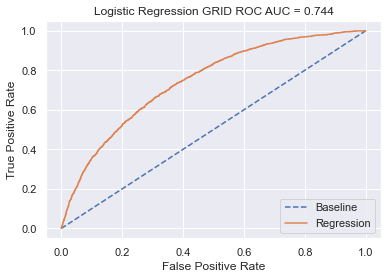

In [54]:
model_grid = LogisticRegression(C= 2.7825594022071245,
                                penalty='l2',
                                random_state=42)
model_grid.fit(X_train, np.ravel(y_train))

probs_grid = model_grid.predict_proba(X_test)
probs_grid = probs_grid[:, 1]

# строим кривую
roc_auc_curve(y_test, probs_grid, 'Logistic Regression GRID ROC AUC = %0.3f', 'Regression')

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     12933
           1       0.40      0.02      0.05      1827

    accuracy                           0.87     14760
   macro avg       0.64      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760



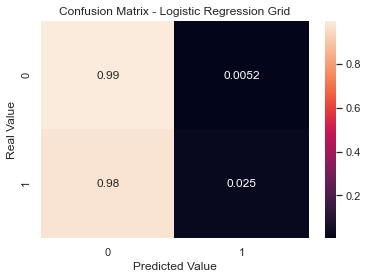

In [55]:
y_pred_grid = model_grid.predict(X_test)

# выводим classification_report и confusion_matrix
class_matrix(y_test, y_pred_grid, 'Confusion Matrix - Logistic Regression Grid')

Что ж, этот, как мы видим, тоже. Всех дефолтных клиентов определяет как беспроблемных

# Oversampled

In [56]:
#model_over = LogisticRegression(random_state=42)
#model_over.fit(X_train_o, np.ravel(y_train_o))

#param_grid = [
#    {'penalty': ['l1'], 
#     'solver': ['liblinear', 'lbfgs'], 
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr']}, 
#    {'penalty': ['l2'], 
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#     'class_weight':['none', 'balanced'], 
#    'multi_class': ['auto','ovr']}, 
#    {'penalty': ['elasticnet'],
#     'solver': ['saga'],
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr'],},
#    {'penalty': ['none'], 
#     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr']}, 
#]

#gridsearch = GridSearchCV(estimator=model_over,
#param_grid=param_grid)
#gridsearch.fit(X_train, y_train)
#model = gridsearch.best_estimator_
# печатаем параметры
#best_parameters = model.get_params()
#best_parameters

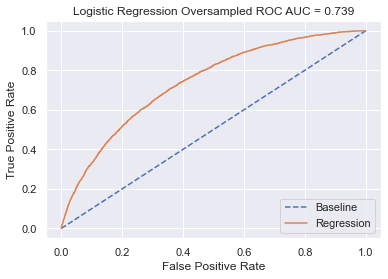

In [57]:
model_grid_o = LogisticRegression(C=1.0,
                                  class_weight=None,
                                  dual=False,
                                  fit_intercept=True,
                                  intercept_scaling=1,
                                  l1_ratio=None,
                                  max_iter=100,
                                  multi_class='auto',
                                  n_jobs=None,
                                  penalty='l2',
                                  solver='lbfgs',
                                  tol=0.0001,
                                  verbose=0,
                                  warm_start=False,
                                  random_state=42)
model_grid_o.fit(X_train_o, np.ravel(y_train_o))

probs_o = model_grid_o.predict_proba(X_test_o)
probs_o = probs_o[:, 1]

# строим кривую
roc_auc_curve(y_test_o, probs_o, 'Logistic Regression Oversampled ROC AUC = %0.3f', 'Regression')

              precision    recall  f1-score   support

           0       0.68      0.67      0.67     12923
           1       0.67      0.68      0.67     12848

    accuracy                           0.67     25771
   macro avg       0.67      0.67      0.67     25771
weighted avg       0.67      0.67      0.67     25771



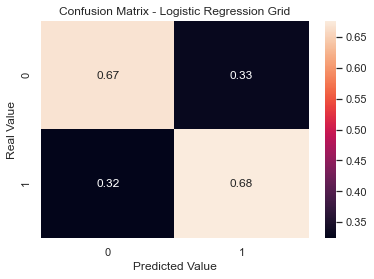

In [58]:
y_pred_o = model_grid_o.predict(X_test_o)

# выводим classification_report и confusion_matrix
class_matrix(y_test_o, y_pred_o, 'Confusion Matrix - Logistic Regression Grid')

Отлично! Кривая стала ниже, но f1_score стал почти в два раза выше линейной регрессии (без участия GridSearchCV)
Oversampled датасет показал себя лучше, опробуем на нем другие модели

In [59]:
preds_over = model_grid_o.predict_proba(test_X)[:,1]

submission_lr = pd.DataFrame({'client_id': client_test, 
                            'default': preds_over})

print(f'Максимальное предсказанное значение:', submission_lr.default.max())
print(f'Максимальное предсказанное значение:', submission_lr.default.min())

Максимальное предсказанное значение: 0.9863645283041267
Максимальное предсказанное значение: 0.023060248799773465


In [60]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')
    
print_regression_metrics(y_test_o, y_pred_o)

MSE = 0.33, RMSE = 0.57


Диапазон предсказанных значений почти максимальный  
При этом ошибка довольно высокая, будем пробовать другие модели

> К сожалению, kaggle даже не дал сохранить работу, в которой я рассмотрела все три вида датасетов (over/undersampling и исходный) и разные виды моделей решений.
Память, выделенная мне платформой, иссякла.
Здесь я покажу варианты, которые прорабатывала, но отказалась впоследствии(ввиду их низкой эффективности), только на oversampled датасете

# Деревья решений  

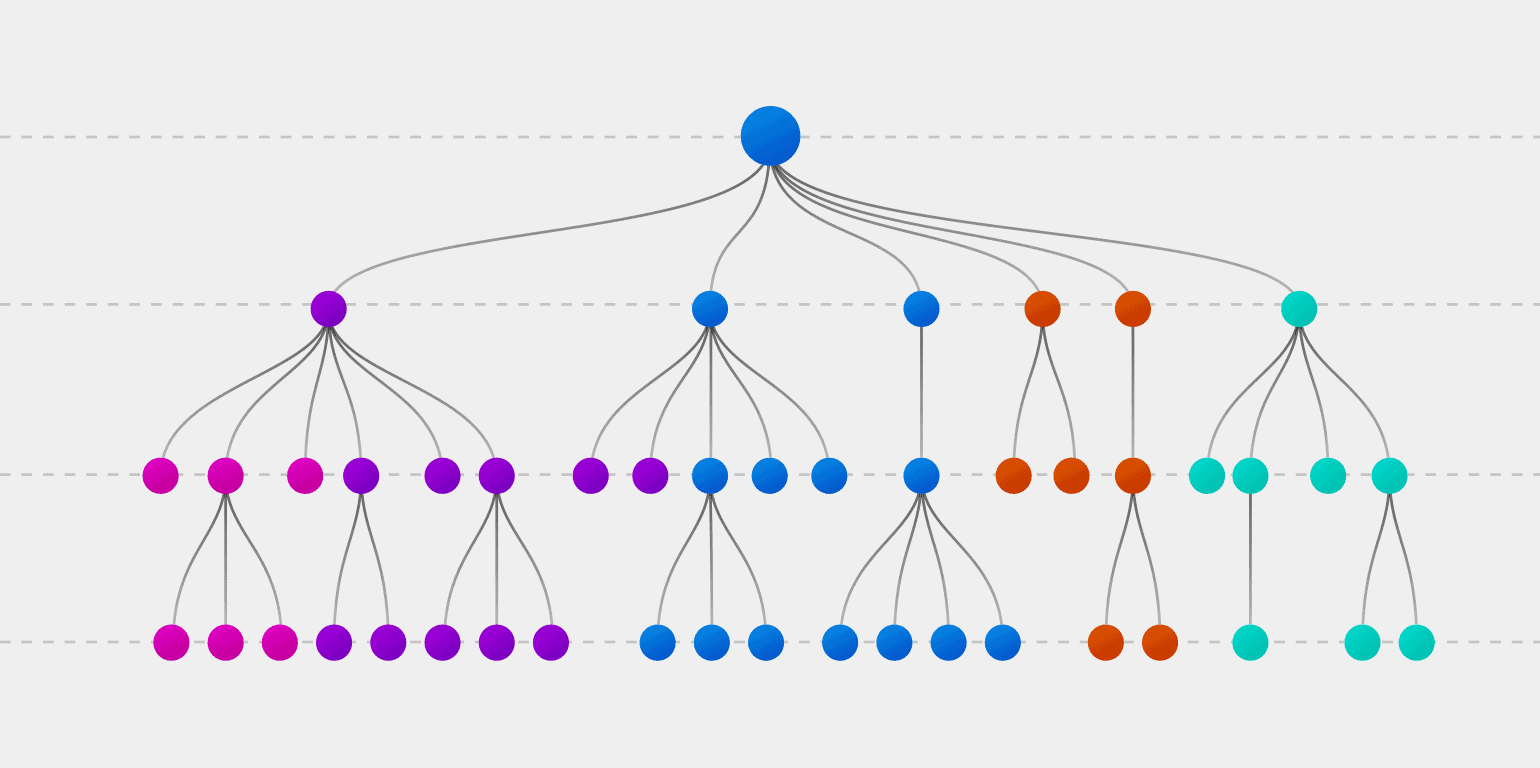

# RandomForestClassifier

Посмотрим сначала, как большое значение влияет на переобучение модели.  
При хороших показателях confusion_matrix и roc_curve на итоговой тестовой выборке значение roc_auc_score падает на 0.1

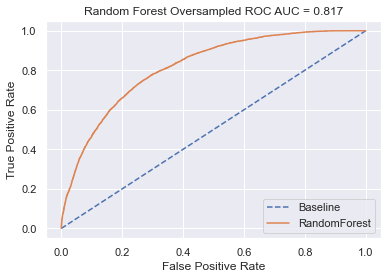

In [61]:
# гиперпараметры подобраны вручную

model_forest = RandomForestClassifier(max_depth=11, random_state=42).fit(X_train_o, y_train_o)
probs_forest = model_forest.predict_proba(X_test_o)
probs_forest = probs_forest[:, 1]

# строим кривую
roc_auc_curve(y_test_o, probs_forest, 'Random Forest Oversampled ROC AUC = %0.3f', 'RandomForest')

              precision    recall  f1-score   support

           0       0.75      0.71      0.73     12923
           1       0.73      0.77      0.75     12848

    accuracy                           0.74     25771
   macro avg       0.74      0.74      0.74     25771
weighted avg       0.74      0.74      0.74     25771



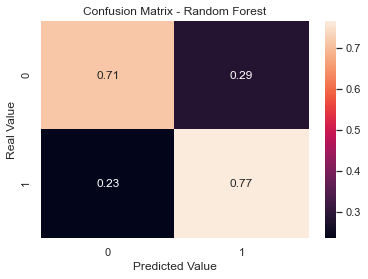

In [62]:
pred_forest = model_forest.predict(X_test_o)

# выводим classification_report и confusion_matrix
class_matrix(y_test_o, pred_forest, 'Confusion Matrix - Random Forest')

In [63]:
preds_forest = model_forest.predict_proba(test_X)[:,1]

submission_forest = pd.DataFrame({'client_id': client_test, 
                            'default': preds_forest})

print(f'Максимальное предсказанное значение:', submission_forest.default.max())
print(f'Максимальное предсказанное значение:', submission_forest.default.min())

Максимальное предсказанное значение: 0.8300302094311784
Максимальное предсказанное значение: 0.0672575409572812


Диапазон предсказанных значений широкий, но меньше чем у логистической регрессии.  

Если же не давать дереву углубиться, то предсказания колеблятся между 0.36 и 0.63  
Интересное поведение, то есть если вглубь не уходить, предсказанные значения будут средними, но если все же увеличить max_depth, то модель быстро переучивается, и на final score значение будем ощутимо ниже

# LightGBM

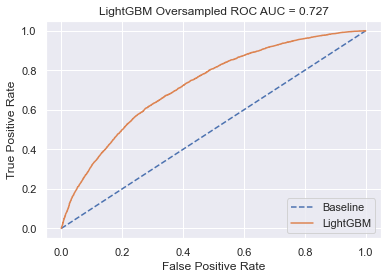

In [64]:
clf_light = LGBMClassifier(learning_rate=0.1,
                           max_depth=1,
                           min_child_weight=1,
                           random_state=42)
clf_light.fit(X_train_o, y_train_o)

probs_light = clf_light.predict_proba(X_test_o)
probs_light = probs_light[:, 1]

# строим кривую
roc_auc_curve(y_test_o, probs_light, 'LightGBM Oversampled ROC AUC = %0.3f', 'LightGBM')

              precision    recall  f1-score   support

           0       0.67      0.66      0.66     12923
           1       0.66      0.67      0.67     12848

    accuracy                           0.66     25771
   macro avg       0.66      0.66      0.66     25771
weighted avg       0.66      0.66      0.66     25771



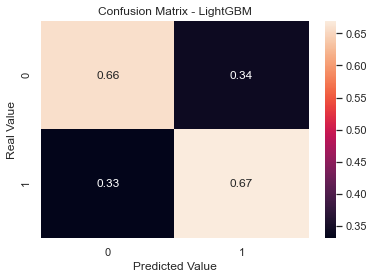

In [65]:
pred_light = clf_light.predict(X_test_o)

# выводим classification_report и confusion_matrix
class_matrix(y_test_o, pred_light, 'Confusion Matrix - LightGBM')

In [66]:
preds_light = clf_light.predict_proba(test_X)[:,1]

submission_light = pd.DataFrame({'client_id': client_test, 
                            'default': preds_light})

print(f'Максимальное предсказанное значение:', submission_light.default.max())
print(f'Максимальное предсказанное значение:', submission_light.default.min())

Максимальное предсказанное значение: 0.8514829937674242
Максимальное предсказанное значение: 0.10830562378112459


В LightGBM выставлены вручную минимальные показатели, чтобы уже не дать модели переобучиться.  
Диапазон предсказанных значений хороший, но метрики качества и кривая ниже, чем у логистической регрессии

# XGBClassifier

На самом деле, я перед тем, как приступить к проекту читала о других моделях и мне больше всего понравилось применение XGBoost для credit scoring.  
Я перепробовала многое, пока не пришла к такому виду:

In [67]:
# чтобы получить производительность модели и построить ее график,
# чтобы понять, как обучение развивалось во время обучения, используем такой eval_set
eval_set = [(X_train_o, y_train_o), (X_test_o, y_test_o)]

clf_gbt = XGBClassifier(random_state=42, min_child_weight=1,
                        max_depth=2).fit(X_train_o,
                                         np.ravel(y_train_o),
                                         eval_metric=["error", "logloss"],
                                         eval_set=eval_set,
                                         verbose=True)

[0]	validation_0-error:0.39090	validation_0-logloss:0.67411	validation_1-error:0.39133	validation_1-logloss:0.67453
[1]	validation_0-error:0.37965	validation_0-logloss:0.66293	validation_1-error:0.38016	validation_1-logloss:0.66333
[2]	validation_0-error:0.36381	validation_0-logloss:0.65397	validation_1-error:0.36599	validation_1-logloss:0.65467
[3]	validation_0-error:0.35273	validation_0-logloss:0.64711	validation_1-error:0.35598	validation_1-logloss:0.64776
[4]	validation_0-error:0.34803	validation_0-logloss:0.64115	validation_1-error:0.34884	validation_1-logloss:0.64141
[5]	validation_0-error:0.34638	validation_0-logloss:0.63689	validation_1-error:0.34745	validation_1-logloss:0.63737
[6]	validation_0-error:0.34586	validation_0-logloss:0.63305	validation_1-error:0.34589	validation_1-logloss:0.63393
[7]	validation_0-error:0.34385	validation_0-logloss:0.62841	validation_1-error:0.34485	validation_1-logloss:0.62935
[8]	validation_0-error:0.34244	validation_0-logloss:0.62577	validation_1

[71]	validation_0-error:0.31899	validation_0-logloss:0.59335	validation_1-error:0.32156	validation_1-logloss:0.59552
[72]	validation_0-error:0.31891	validation_0-logloss:0.59317	validation_1-error:0.32110	validation_1-logloss:0.59530
[73]	validation_0-error:0.31887	validation_0-logloss:0.59306	validation_1-error:0.32087	validation_1-logloss:0.59525
[74]	validation_0-error:0.31842	validation_0-logloss:0.59294	validation_1-error:0.31989	validation_1-logloss:0.59511
[75]	validation_0-error:0.31867	validation_0-logloss:0.59286	validation_1-error:0.31997	validation_1-logloss:0.59503
[76]	validation_0-error:0.31865	validation_0-logloss:0.59281	validation_1-error:0.31997	validation_1-logloss:0.59503
[77]	validation_0-error:0.31879	validation_0-logloss:0.59273	validation_1-error:0.32001	validation_1-logloss:0.59498
[78]	validation_0-error:0.31861	validation_0-logloss:0.59263	validation_1-error:0.31982	validation_1-logloss:0.59493
[79]	validation_0-error:0.31842	validation_0-logloss:0.59252	val

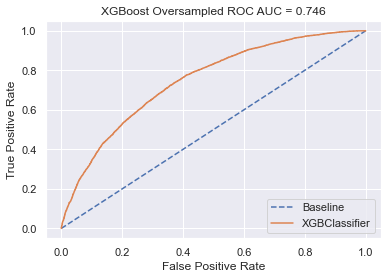

In [68]:
prob_gbt = clf_gbt.predict_proba(X_test_o)[:, 1]

# строим кривую
roc_auc_curve(y_test_o, prob_gbt, 'XGBoost Oversampled ROC AUC = %0.3f', 'XGBClassifier')

              precision    recall  f1-score   support

           0       0.69      0.66      0.68     12923
           1       0.67      0.70      0.69     12848

    accuracy                           0.68     25771
   macro avg       0.68      0.68      0.68     25771
weighted avg       0.68      0.68      0.68     25771



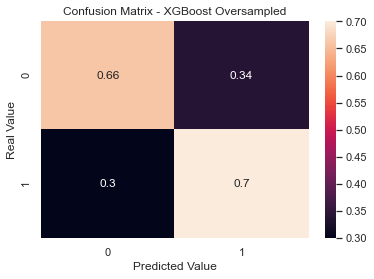

In [69]:
pred_gbt = clf_gbt.predict(X_test_o)

# выводим classification_report и confusion_matrix
class_matrix(y_test_o, pred_gbt, 'Confusion Matrix - XGBoost Oversampled')

In [70]:
probs_gbt = clf_gbt.predict_proba(test_X)[:,1]

submission_gbt = pd.DataFrame({'client_id': client_test, 
                            'default': probs_gbt})

print(f'Максимальное предсказанное значение:', submission_gbt.default.max())
print(f'Максимальное предсказанное значение:', submission_gbt.default.min())

Максимальное предсказанное значение: 0.9615431427955627
Максимальное предсказанное значение: 0.017987042665481567


Пока самые лучшие показатели. И самый широкий диапазон предсказанных значений.  
Посмотрим на функцию ошибки

In [71]:
# сделаем предсказания чуть иначе (округлим их)
y_predx = clf_gbt.predict(X_test_o)
predictions = [round(value) for value in y_predx]

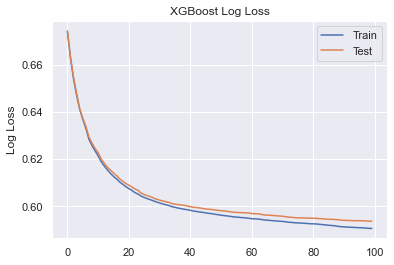

In [72]:
# извлечем метрики
results = clf_gbt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# рисуем log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

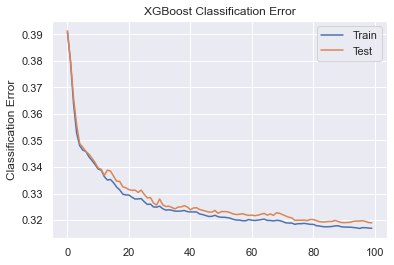

In [73]:
#рисуем classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

Неплохие, пусть и не идеальные функции ошибок, и в целом, результаты лучше, чем у логистической регрессии 

Значения min_child_weight=1, max_depth=2 оказались самыми оптимальными. С одной стороны минимальный min_child_weight позволяет алгоритму создавать дочерние элементы, которые соответствуют меньшему количеству образцов. Это позволяет создавать более сложные деревья, но, опять же, с большей вероятностью переобучения. Поэтому мы выставили больше минимального значения.
А вот глубину дерева оставили минимальной.  

Посмотрим, как выглядит наше дерево. К сожалению, оно будет в не раскодированном виде

In [74]:
#fig, ax = plt.subplots(figsize=(12, 12))
#plot_tree(clf_gbt, ax=ax)
#plt.show()


# Jupyter, в отличие от Kaggle не хочет выводить дерево, мы приведем его иначе

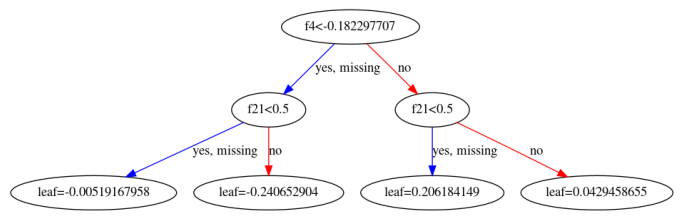

Лучшие показатели были у логистической регрессии сбалансированного датасета и XGBoost дерева, посмотрим, как они предсказывают данные на обучающей выборке, при помощи calibration_curve

In [75]:
frac_pos_lr, mean_pred_lr = calibration_curve(y_test_o, probs_o, n_bins=5)

In [76]:
frac_pos_gbt, mean_pred_gbt = calibration_curve(y_test_o, prob_gbt, n_bins=5)

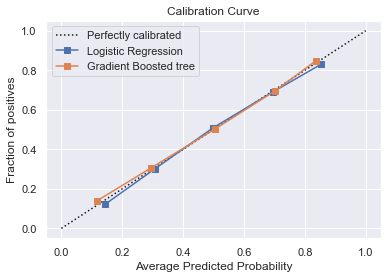

In [77]:
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_lr, frac_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(frac_pos_gbt, mean_pred_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Выводы.  

1. GridSearchCV мне так и не поддался, он выдает либо те гиперпараметры, которые делают моей модели хуже, либо те, что ее никак не меняют.  
2. Логистическая регрессия для несбалансированной выборки ожидаемо выдает f1_score выше для класса-большинства, тогда как на несбалансированной ведет себя лучше: метрики качества стали выше, пусть кривая и спустилась.  
3. XGBClassifier показал себя хорошо, на прежних сабмитах он тоже себя вел лучше, но на лидерборде показывал score ниже, чем логистическая регрессия.  В этот раз я поработала вплотную с гиперпараметрами дерева, посмотрим, что выйдет
4. Я выбрала XGBoost так как по матрице он пусть не намного, но лучше предсказывает значения f1_score для дефолта. По функциям ошибок и calibration_curve чуть ли не идеальный (чуууть лучше чем у логистической регрессии), но нет, в итоге показывает себя не так хорошо.
5. Мне очень хотелось добиться высоких результатах именно на деревьях решений, возможно, нужно иначе обрабатывать данные. Удаления столбцов снижали score. Пробовала использовать DMatrix, но не смогла найти есть ли альтернатива predict_proba в ней.

In [78]:
submission_gbt.to_csv('submission_gbt.csv', index=False)
submission_gbt.head(10)

,client_id,default
0,74835,0.219413
1,17527,0.759262
2,75683,0.371082
3,26883,0.367911
4,28862,0.131271
5,99881,0.509350
6,26630,0.806421
7,79934,0.258541
8,16605,0.133963
9,105449,0.107013
